This notebook focus on the following objectives:
1. Create a set of baseline results for the subband allocation challenge
2. Create and test  scoring metrics.

In [19]:
# !git clone https://github.com/RubenCid35/6GSmartRRM.git

In [20]:
# simple data manipulation
import numpy  as np
import pandas as pd

# progress bar
from   tqdm.notebook import tqdm, trange

# remove warnings (remove deprecated warnings)
import warnings
warnings.simplefilter('ignore')

# visualization of results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from   matplotlib.ticker import MaxNLocator
import seaborn           as sns

# Graph Algorithms.
import networkx as nx

# Google Colab (many lines are removed)
import os
import zipfile
# from google.colab import drive
# from distutils.dir_util import copy_tree

# wheter we are using colab or not
COLAB: bool = False
if not COLAB and not os.path.exists('./data/simulations'): 
    os.chdir('..')

# Simulation Settings
from g6smart.sim_config import SimConfig
config = SimConfig(0)
config

Simulation Parameters: 

|                      name |                     value |
---------------------------------------------------------
|        num_of_subnetworks |                   20.0000 |
|              n_subchannel |                    4.0000 |
|             deploy_length |                   20.0000 |
|             subnet_radius |                    1.0000 |
|                      minD |                    0.8000 |
|               minDistance |                    2.0000 |
|                 bandwidth |             40000000.0000 |
|              ch_bandwidth |             10000000.0000 |
|                        fc |           6000000000.0000 |
|                    lambdA |                    0.0500 |
|                  clutType |                     dense |
|                  clutSize |                    2.0000 |
|                  clutDens |                    0.6000 |
|                   shadStd |                    7.2000 |
|                 max_power |                  

## Simulations and Information

Thanks to the given scripts, we can load a group of generated simulations. They don't have any solutions (neither approximations).

In [21]:
# Moung Google Drive Code
if COLAB:
    # drive.mount('/content/drive')

    # Move Simulations to avoid cluttering the drive folder
    # if not os.path.exists('/content/simulations'):
    #   os.mkdir('/content/simulations')

    # if list(os.listdir('/content/simulations')) == []:
    #   copy_tree('/content/drive/MyDrive/TFM/simulations', '/content/simulations')

    # unzip all simulations
    # print("Name of the already simulated data: \n", )
    for zip_file in os.listdir('/content/simulations'):
        if zip_file.endswith('.zip'):
            print(" ----> " + zip_file)
            with zipfile.ZipFile("/content/simulations/" + zip_file, 'r') as zip_ref:
                zip_ref.extractall('/content/simulations/')

    SIMULATIONS_PATH: str = "/content/simulations"
else:
    if not os.path.exists('./data/simulations'): os.mkdir('./data/simulations')
    for zip_file in os.listdir('data'):
        if zip_file.endswith('.zip'):
            print(" ----> " + zip_file)
            with zipfile.ZipFile("./data/" + zip_file, 'r') as zip_ref:
                zip_ref.extractall('./data/simulations')
    SIMULATIONS_PATH: str = "./data/simulations"

## Generation of Approximate Allocations and Power

There are different approaches to generate different subband allocations. For starters, we will define all the algorithmic baselines that do not require the training or adjustment of the method to generate results.

In [22]:
loc = np.load(SIMULATIONS_PATH + '/Location_mat.npy')
cmg = np.load(SIMULATIONS_PATH + '/Channel_matrix_gain.npy')

# for this test, we only consider some cases
shape    = lambda s: " x".join([f"{d:3d}" for d in s])
print(f"location matrix shape: {shape(loc.shape)}\nchannel  matrix shape: {shape(cmg.shape)}")

location matrix shape: 200000 x 20 x  2
channel  matrix shape: 200000 x  4 x 20 x 20


### SISA Algorithm

To generate a list of initial approximations for training, we can apply [SISA](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10118695) (Sequential Iterative Sub-band Allocation). This method allows us to generate almost-optimal approximations.

To apply this method, we need to consider that two things:

* the calculations require setting an initial transmission power. As  this is one of the proposed task, we can fix the value or setting other.

* The results are a baseline. ¿Should we remove it from the table?

For the initial power settings, we will fix a value, it is not necessary to know the value as it disappears in the calculations at the start. 
The algorithm will be iterated over 20 iterations.

In [23]:
def weighted_interference_matrix(channel_gain: np.ndarray) -> np.ndarray:
    """
    Computes the weighted interference matrix W based on the channel gain matrix.

    Parameters:
    - channel_gain (np.ndarray): A (K, N, N) array representing the channel gains 
      between different nodes and subnetworks.

    Returns:
    - W (np.ndarray): A (K, N, N) matrix where W[k, i, j] represents the 
      interference weight from node i to node j in subnetwork k.
    """
    # Compute direct channel gains and normalize interference
    Hd = np.expand_dims(np.diagonal(channel_gain, 0, 1, 2), 2)
    W  = np.where(Hd > 0, channel_gain / Hd , 0)
    
    #  remove self-interference
    for k in range(W.shape[0]): np.fill_diagonal(W[k], 0)

    return W

def sisa_algoritm(channel_gain: np.ndarray, max_iter: int = 3) -> tuple[np.ndarray, np.ndarray]:
    """
    Implements the Sequential Iterative Subband Allocation (SISA) Algorithm

    The algorithm iteratively assigns each subnetwork to a subband that minimizes the sum weighted
    interference of the whole network while ensuring a fair allocation.

    Args:
        - channel_gain (np.ndarray): A (K, N, N) array representing the channel gains.
        - max_iter (int): The maximum number of iterations for optimization. Defaults to 3 iterations.

    Returns:
        - A (np.ndarray): An (N, ) array where A[n] represents the assignment of the subnetwork n to the subband k.
        - F (np.ndarray): An (N x max_iter) array with a list of values of the sum interference of each step. 
    
    Reference:
        - [Advanced Frequency Resource Allocation for Industrial Wireless Control in 6G subnetworks](https://ieeexplore.ieee.org/document/10118695) 
    """
    K, N, _ = channel_gain.shape
    
    # inititalize inputs
    A = np.zeros((N)   , dtype=int) # A : N -> K
    B = np.zeros((K, N), dtype=int) # B_k : {n \in N : A(n) = k}
    
    # first all networks are assigned to the same subband
    B[0, :] = 1

    W = weighted_interference_matrix(channel_gain)
    total_interference = []

    # procedure
    for _ in range(1, max_iter + 1):
        for n in range(N):
            # 1. compute iteration number : not required
            # 2. compute w_k (d) for all k
            w_k  = np.sum(B * (W[:, n, :] + W[:, :, n]), axis = 1)

            # 3. determine interim allocation A
            A[n] = np.argmin(w_k)

            # 4. determine interim allocation B based on A
            B[:, :] = 0 # reset allocations
            B[A, np.arange(N)] = 1
            
            # 5. compute sum weighted interference
            mask = B[A, :]
            F = np.sum(W[A[:, None], np.arange(N)[:, None], np.where(mask == 1)[1]])            
            total_interference.append(F)
    
    return A, np.array(total_interference)


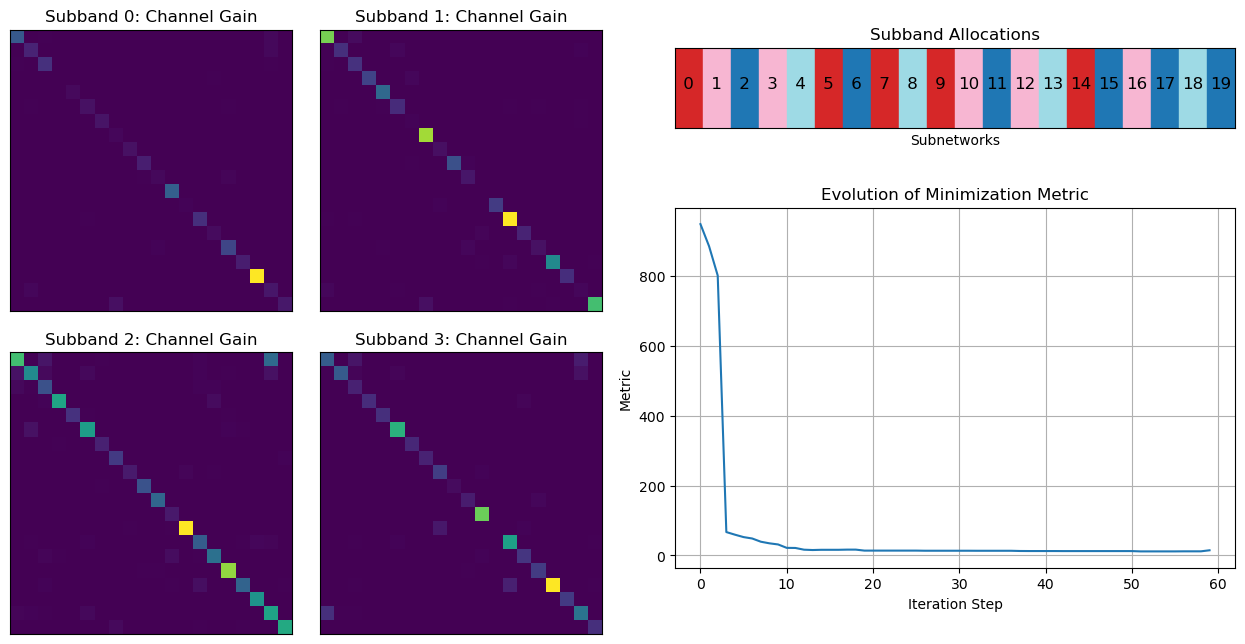

In [24]:

def plot_allocation_results(allocation: np.ndarray, metric: np.ndarray, config: SimConfig):
    fig = plt.figure(figsize = (14, 8))
    outer = gridspec.GridSpec(1, 2, figure=fig, wspace = 0.2, hspace = 0.2, width_ratios = [6, 4])

    bands_grid = gridspec.GridSpecFromSubplotSpec(2, 2, outer[0], wspace = 0.1, hspace = 0.1)
    for k in range(config.n_subchannel):
        ax = plt.Subplot(fig, bands_grid[k])
        ax.imshow(channel_gain[k])
        ax.set_xticks([])    
        ax.set_yticks([])
        ax.set_title(f"Subband {k}: Channel Gain")
        fig.add_subplot(ax)

    result = gridspec.GridSpecFromSubplotSpec(2, 1, outer[1], wspace = 0.1, hspace = 0.1, height_ratios=[2, 8])

    ax = plt.Subplot(fig, result[0])  
    ax.set_xticks([])  # Hide x-ticks
    ax.set_yticks([])  # Hide y-ticks
    ax.set_title("Subband Allocations")
    ax.set_xlabel("Subnetworks")
    ax.set_xlim(0, allocation.shape[0])

    ax.set_position([0.6, 0.75, 0.4, 0.1])

    # Define a colormap to represent allocation values
    K = config.n_subchannel  # Assume max value of allocation is K
    colors = plt.cm.get_cmap('tab20', K)

    # Plot the colored boxes for the network allocation
    for i, alloc in enumerate(allocation):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=colors(alloc)))  # Create colored boxes
        ax.text(i + 0.1, 0.5, f"{i:>2d}", fontsize = 12)
    fig.add_subplot(ax)

    if metric is not None:
        ax = plt.Subplot(fig, result[1])
        ax.plot(metric)
        ax.set_xlabel("Iteration Step")
        ax.set_ylabel("Metric")
        ax.set_title("Evolution of Minimization Metric")
        ax.grid()
        ax.set_position([0.6, 0.2, 0.4, 0.45])
        fig.add_subplot(ax)

    fig.show()

# for example
channel_gain = cmg[0]
allocation, inteference = sisa_algoritm(channel_gain, 3)
plot_allocation_results(allocation, inteference, config)

### Centralized Graph Coloring Algorithm
This method does not require to define the any power settings. We

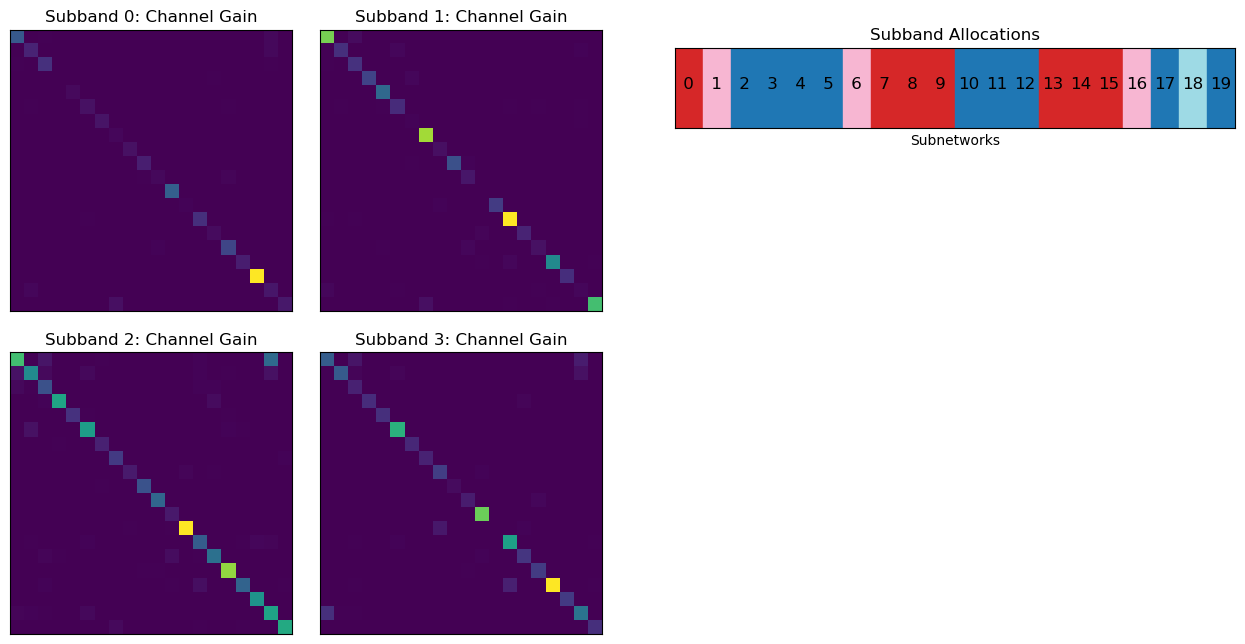

In [25]:
def cgc_algoritm(channel_gain: np.ndarray, n_channel: int = 4) -> np.ndarray:
    """
    Implements the Centralized Graph Coloring 

    Args:
        channel_gain (np.ndarray): _description_
        n_channel (int, optional): _description_. Defaults to 4.

    Returns:
        np.ndarray: _description_
    """

    # estimate the pair-wise interference matrix 
    X = np.sum(channel_gain, axis = 0)
    np.fill_diagonal(X, np.inf) # disable self-interference

    GM = np.ones(X.shape, dtype = int)
    np.fill_diagonal(GM, 0) # disable self-interference

    # create conflict graph
    G = nx.from_numpy_array(X)

    # apply gready coloring
    C = nx.coloring.greedy_color(G, strategy='largest_first')
    
    # remove edges while
    n_iteration = 0
    while max(C.values()) >= n_channel:
        # remove edge with least interference
        edge = np.unravel_index(np.argmin(X), X.shape)
        X[edge] = np.inf
        GM[edge] = 0

        # recompute coloring
        G = nx.from_numpy_array(GM)
        C = nx.coloring.greedy_color(G, strategy='largest_first')
        n_iteration += 1

    allocation = np.zeros((X.shape[0], ), dtype = int)
    for n in range(X.shape[0]): allocation[n] = C[n]
    return allocation

allocation = cgc_algoritm(channel_gain, 4)
plot_allocation_results(allocation, None, config)

## Generating Samples

For the deep learning models, we will define baselines for the subband allocation than can be learned.
After seeing the results of each method, we conclude that we can use SISA for the generation of results.

In [26]:
n_sample = cmg.shape[0]
n_device = cmg.shape[2]

if not os.path.exists('./data/simulations/sisa-allocation.npy'):
    # generate results
    results = np.zeros((n_sample, n_device))
    for sample_id in trange(n_sample, desc="generating sample results:"):
        channel_gain = cmg[sample_id]
        # for simplicity and based of previous results, we can set to 1-2 results. 
        # They don't need to be an optimal results
        allocation   = sisa_algoritm(channel_gain, 2)[0]
        results[sample_id] = allocation

    # save results
    np.save('./data/simulations/sisa-allocation.npy', results)


## Evaluation Metrics

### Bit-Rate 
The general formula for the bitrate on a given subnetwork can be expressed as:

$$Rate=B \times log⁡_2( 1 + SINR)$$

Where:
* $B$ is the bandwidth of the subband (defined in settings)
* ***SINR*** (Signal-to-Interference-Ratio) can be derived from the channel gain matrix. We can use the following formula
    $$ \text{SINR}_{i,k} = \dfrac{P_i * G_{k, ii}}{\sum_{j \ne i} P_j G_{k,ij} + N_0} $$
    
    With:

    * $G_{k, ii}$ is the  channel gain for the subnetwork $i$ with its associated subband $k$
    * $P_{i}$   is the tranmission power for the subnetwork $i$
    * $N_0$ is the noise power spectral density (from simulation settings)
    

In [27]:

def signal_interference_ratio(
        config: SimConfig, 
        channel_gain: np.ndarray,
        allocation: np.ndarray,
        power: np.ndarray | float
    ) -> np.ndarray:
    K, N, _ = channel_gain.shape
    noise = config.noise_power # 10 ** (config.noise_figure_db / 10 - 3)

    # Ensure allocations are within valid subband indices [0, K-1]
    assert np.max(allocation) < K and allocation.shape[0] == N, \
           "Each subnetwork must have an allocated subband from 0 to K - 1"

    # Ensure power is an array of shape (N,)
    power = np.full((N,), power) if isinstance(power, (float, int)) else power
    assert power.shape[0] == N, "Each subnetwork must have a power assignment at least"

    sinr = np.zeros((N, ))
    for n, k in enumerate(allocation):
        signal = channel_gain[k, n, n] * power[n]

        # estimate the interference
        masked_power = power * (allocation == k)
        interference = np.dot(channel_gain[allocation, np.arange(N), n], masked_power)
        interference = interference - signal # remove self-interference

        sinr[n] = signal / (interference + noise + 1e-9)

    return sinr

def bit_rate(
        config: SimConfig, 
        channel_gain: np.ndarray,
        allocation: np.ndarray,
        power: np.ndarray | float
    ) -> np.ndarray:
    K, N, _ = channel_gain.shape
    B  = config.ch_bandwidth
    SINR = signal_interference_ratio(config, channel_gain, allocation, power)
    return B * np.log2(SINR + 1) / 1e6

print("Transmit      Power:", config.transmit_power)
print("SubBand - Bandwidth: ", config.ch_bandwidth)

B = config.ch_bandwidth
# allocation1 = np.zeros((20, ), dtype = int)
allocation1, _  = sisa_algoritm(cmg[1], 4)
SINR = signal_interference_ratio(config, cmg[1], allocation1, config.transmit_power)
rate = (B * np.log2(SINR + 1)) / 1e6
print(f"min SINR: {np.min(SINR):7.4f}    \tavg SINR: {np.mean(SINR):7.4f}    \tmax SINR: {np.max(SINR):7.4f} ")
SINR = 10 * np.log10(SINR)
print(f"min SINR: {np.min(SINR):7.4f} dbm\tavg SINR: {np.mean(SINR):7.4f} dbm\tmax SINR: {np.max(SINR):7.4f} dbm")
print(f"min rate: {np.min(rate):7.4f}    \tavg rate: {np.mean(rate):7.4f}    \tmax rate: {np.max(rate):7.4f} ")

Transmit      Power: 0.001
SubBand - Bandwidth:  10000000.0
min SINR:  5.9458    	avg SINR: 28.4195    	max SINR: 56.8806 
min SINR:  7.7421 dbm	avg SINR: 13.8177 dbm	max SINR: 17.5496 dbm
min rate: 27.9615    	avg rate: 46.6228    	max rate: 58.5501 


Using SISA Algorithm: 
min SINR: 8.4517	avg SINR: 13.7900	max SINR: 21.8921
min rate: 30.0020	avg rate: 46.5668	max rate: 72.8169	total: 931.3358

Using CGC Algorithm: 
min SINR: -15.0844	avg SINR: 9.5508	max SINR: 21.0892
min rate: 0.4406	avg rate: 36.1929	max rate: 70.1687	total: 723.8582

Using Dummy Allocation (all the same): 
min SINR: -17.6506	avg SINR: 4.9210	max SINR: 20.0916
min rate: 0.2457	avg rate: 23.8680	max rate: 66.8834	total: 477.3603


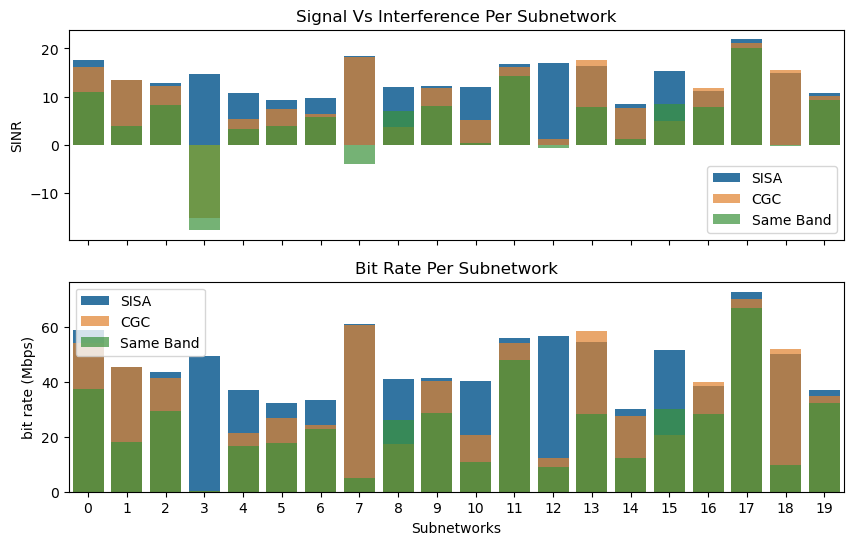

In [28]:
_, ax = plt.subplots(2, 1, figsize = (10, 6), sharex = True)

B = config.ch_bandwidth
allocation1, inteference = sisa_algoritm(channel_gain, 3)
SINR = signal_interference_ratio(config, channel_gain, allocation1, config.transmit_power)
rate = (B * np.log2(SINR + 1)) / 1e6
SINR = 10 * np.log10(SINR)

print("Using SISA Algorithm: ")
print(f"min SINR: {np.min(SINR):6.4f}\tavg SINR: {np.mean(SINR):6.4f}\tmax SINR: {np.max(SINR):6.4f}")
print(f"min rate: {np.min(rate):6.4f}\tavg rate: {np.mean(rate):6.4f}\tmax rate: {np.max(rate):6.4f}\ttotal: {np.sum(rate):7.4f}")
sns.barplot(x = np.arange(20), y = SINR, ax = ax[0], label = "SISA")
sns.barplot(x = np.arange(20), y = rate, ax = ax[1], label = "SISA")

allocation2 = cgc_algoritm(channel_gain, channel_gain.shape[0])
SINR = signal_interference_ratio(config, channel_gain, allocation2, config.transmit_power)
rate = (B * np.log2(SINR + 1)) / 1e6
SINR = 10 * np.log10(SINR)

print("\nUsing CGC Algorithm: ")
print(f"min SINR: {np.min(SINR):6.4f}\tavg SINR: {np.mean(SINR):6.4f}\tmax SINR: {np.max(SINR):6.4f}")
print(f"min rate: {np.min(rate):6.4f}\tavg rate: {np.mean(rate):6.4f}\tmax rate: {np.max(rate):6.4f}\ttotal: {np.sum(rate):7.4f}")

sns.barplot(x = np.arange(20), y = SINR, ax = ax[0], alpha = 0.7, label = "CGC")
sns.barplot(x = np.arange(20), y = rate, ax = ax[1], alpha = 0.7, label = "CGC")

allocation3 = np.zeros((20, ), dtype = int)
SINR = signal_interference_ratio(config, channel_gain, allocation3, config.transmit_power)
rate = (B * np.log2(SINR + 1)) / 1e6
SINR = 10 * np.log10(SINR)

print("\nUsing Dummy Allocation (all the same): ")
print(f"min SINR: {np.min(SINR):6.4f}\tavg SINR: {np.mean(SINR):6.4f}\tmax SINR: {np.max(SINR):6.4f}")
print(f"min rate: {np.min(rate):6.4f}\tavg rate: {np.mean(rate):6.4f}\tmax rate: {np.max(rate):6.4f}\ttotal: {np.sum(rate):7.4f}")

sns.barplot(x = np.arange(20), y = SINR, ax = ax[0], alpha = 0.7, label = "Same Band")
sns.barplot(x = np.arange(20), y = rate, ax = ax[1], alpha = 0.7, label = "Same Band")


ax[0].set_title("Signal Vs Interference Per Subnetwork")
ax[1].set_title("Bit Rate Per Subnetwork")
ax[0].set_ylabel("SINR")
ax[1].set_ylabel("bit rate (Mbps)")
ax[1].set_xlabel("Subnetworks")
ax[0].legend()

### Performance Loss Factor
The PLF (**Performance Loss Factor**) in network evaluation is a measure that quantifies the inefficiency or degradation in performance due to various factors, such as interference, resource allocation issues, or suboptimal configurations

In [29]:
def proportional_loss_factor(
        config: SimConfig, 
        channel_gain: np.ndarray,
        allocation: np.ndarray,
        power: np.ndarray | float
    ) -> float:
    _, N, _ = channel_gain.shape
    # all subnetworks have the same bandwidth
    B  = config.ch_bandwidth
    N0 = config.noise_power
    
    # estimate SINR 
    rate = bit_rate(config, channel_gain, allocation, power)

    # calculate ideal conditions
    ideal_snir = channel_gain[allocation, np.arange(N), np.arange(N)] * power / (N0 + 1e-9)
    ideal = B * np.log2(ideal_snir + 1) / 1e6

    return np.sum(rate) / np.sum(ideal)

print("PLF Values Per Algorithm: ")
print("SISA  Algorithm: %8.6f" % (proportional_loss_factor(config, channel_gain, allocation1, config.transmit_power), ))
print("CGC   Algorithm: %8.6f" % (proportional_loss_factor(config, channel_gain, allocation2, config.transmit_power), ))
print("Dummy Algorithm: %8.6f" % (proportional_loss_factor(config, channel_gain, allocation3, config.transmit_power), ))
print()

PLF Values Per Algorithm: 
SISA  Algorithm: 0.964793
CGC   Algorithm: 0.921990
Dummy Algorithm: 0.635483



In [30]:
def jain_fairness(rate: np.ndarray) -> float:
    upper = np.sum(rate) ** 2
    lower = rate.shape[0] * np.sum(np.power(rate, 2))
    return upper / lower

print("PLF Values Per Algorithm: ")
print("SISA  Algorithm: %8.6f" % (jain_fairness(bit_rate(config, channel_gain, allocation1, config.transmit_power)), ))
print("CGC   Algorithm: %8.6f" % (jain_fairness(bit_rate(config, channel_gain, allocation2, config.transmit_power)), ))
print("Dummy Algorithm: %8.6f" % (jain_fairness(bit_rate(config, channel_gain, allocation3, config.transmit_power)), ))
print()

PLF Values Per Algorithm: 
SISA  Algorithm: 0.948676
CGC   Algorithm: 0.800875
Dummy Algorithm: 0.712838

